In [11]:
!pip install chronos-forecasting fev boto3

In [12]:
from chronos import BaseChronosPipeline
import chronos
import torch
import numpy as np
from matplotlib import pyplot as plt
from typing import Sequence, Mapping, Optional
import types
from chronos.chronos2.dataset import Chronos2Dataset, DatasetMode, TensorOrArray
from tqdm import tqdm
import datasets
import pandas as pd
from functools import partial
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.seasonal import STL
import fev

Run Chronos-2 on a test time series and plot the result, to ensure Chronos-2 is working properly.

We also plot the moving average of the input time series.

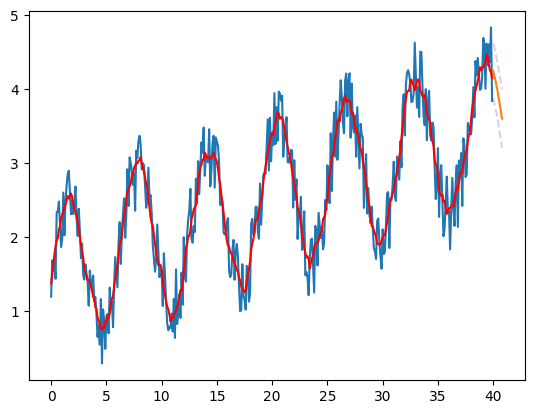

In [13]:
pipeline = BaseChronosPipeline.from_pretrained("autogluon/chronos-2", device_map="cuda", torch_dtype=torch.float32)

def test_prediction(pipeline):
  timestep=0.1
  t = np.arange(400)*timestep
  sin_input = np.sin(t) + 0.05*t + 1

  sin_input += np.random.random(size=len(t))

  n = 9
  inputs = np.reshape(sin_input, (1, 1, -1))

  t_pred = t.max() + timestep + np.arange(n)*timestep
  pred_quants, pred_means = pipeline.predict_quantiles(inputs, prediction_length=n, quantile_levels=[0.1, 0.5, 0.9])

  K=9
  ma = np.pad(sin_input, (K//2, K-1-K//2), mode='edge')
  moving_avg = np.convolve(ma, np.ones(K)/K, mode='valid')

  fig, ax = plt.subplots()
  ax.plot(t, sin_input)
  ax.plot(t, moving_avg, color="red")
  ax.plot(t_pred, pred_means[0][0])

  ax.plot(t_pred, pred_quants[0][0,:,0], label='0.1 quantile', color='purple', linestyle='--', alpha=0.2)
  ax.plot(t_pred, pred_quants[0][0,:,2], label='0.9 quantile', color='purple', linestyle='--', alpha=0.2)

test_prediction(pipeline)

This is the implementation of the extension. The function 'predict_quantiles' is a standin for the Chronos-2 pipeline's 'predict_quantiles' function. It allows for an injector and an interpreter.

The covariate injectors of f and g are the functions 'augment1' and 'augment2' respectively.

The multivariate injectors are 'cov_injector1' and 'cov_injector2' respectively.

To combine the multivariate predictions back into a univariate prediction (approach 2), there are 'interpret1' and 'interpret2' respectively.

In [14]:
def predict_quantiles(  # type: ignore[override]
    self,
    inputs: TensorOrArray
    | Sequence[TensorOrArray]
    | Sequence[Mapping[str, TensorOrArray | Mapping[str, TensorOrArray]]],
    prediction_length: int | None = None,
    quantile_levels: list[float] = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    injector=None,
    interpreter=None,
    **predict_kwargs):

  print("Starting predict")
  mus = []
  sigmas = []
  if injector is not None:
    for map in inputs:
      mus.append(np.nanmean(map["target"][0]))
      sigmas.append(np.nanstd(map["target"][0]))
      injector(map)
  print("Injected covariates...")

  pred = self.original_predict_quantiles(inputs, prediction_length, quantile_levels, **predict_kwargs)

  print("Prediction made... Now interpreting")

  if interpreter is not None:
    return interpreter(pred, mus=mus, sigmas=sigmas)
  else:
    return pred

def augment1(map):
  targ = map["target"][0]
  targ = (targ - np.nanmean(targ))/np.nanstd(targ)
  exp = np.exp(targ);
  cube = np.pow(targ, 3)
  return {
    "cube": cube,
    "exp": exp,
    "inv": -targ,
    "ncube": -cube,
    "nexp": -exp
  }

def augment2(map):
  K = 9
  targ = map["target"][0]
  ma = np.pad(targ, (K//2, K-1-K//2), mode='edge')
  ma = np.convolve(ma, np.ones(K)/K, mode='valid')
  return {
    "ma": ma,
    "res": targ - ma
  }

def interpret1(pred, mus, sigmas):
  def inv(tensor):
    return torch.stack([
        tensor[0],
        torch.sign(tensor[1]) * torch.pow(torch.abs(tensor[1]), 1/3),
        torch.log(torch.clamp(tensor[2], min=0.01)),
        -tensor[3],
        torch.sign(-tensor[4]) * torch.pow(torch.abs(-tensor[4]), 1/3),
        torch.log(torch.clamp(-tensor[5], min=0.01)),
    ])

  list_quantiles = [inv(t) for t in pred[0]]
  list_preds = [inv(t) for t in pred[1]]
  list_quantiles = [torch.vstack([p[:3], p[3:].flip(2)]) for p in list_quantiles]
  list_quantiles = [torch.vstack([
      p[0].unsqueeze(0),
      p[1:]*sigma + mu]) for p, mu, sigma in zip(list_quantiles, mus, sigmas)]
  list_preds = [torch.vstack([
      p[0].unsqueeze(0),
      p[1:]*sigma + mu]) for p, mu, sigma in zip(list_preds, mus, sigmas)]
  list_quantiles = [torch.mean(p, 0).unsqueeze(0) for p in list_quantiles]
  list_preds = [torch.mean(p, 0).unsqueeze(0) for p in list_preds]
  return list_quantiles, list_preds

def interpret2(pred, **kwargs):
  list_quantiles = pred[0]
  list_preds = pred[1]
  list_quantiles = [0.5 * (p[0] + torch.sum(p[1:], 0)).unsqueeze(0) for p in list_quantiles]
  list_preds = [0.5 * (p[0] + torch.sum(p[1:], 0)).unsqueeze(0) for p in list_preds]
  return list_quantiles, list_preds

# def interpret2(pred):
#   list_quantiles = pred[0]
#   list_preds = pred[1]
#   list_quantiles = [torch.mean(p, 0).unsqueeze(0) for p in list_quantiles]
#   list_preds = [torch.mean(p, 0).unsqueeze(0) for p in list_preds]
#   return list_quantiles, list_preds

def cov_injector1(map):
  map["past_covariates"] = augment1(map)

def cov_injector2(map):
  map["past_covariates"] = augment2(map)

def mul_injector1(map):
  map["target"] = np.vstack([map["target"], *augment1(map).values()])

def mul_injector2(map):
  map["target"] = np.vstack([map["target"], *augment2(map).values()])




Define the function that will perform the Fev task and override the predict_quantile function in the pipeline.

In [15]:


def predict_with_model(
    task: fev.Task,
    batch_size: int = 100,
    device_map: str = "cuda",
    torch_dtype: torch.dtype = torch.float32,
    as_univariate: bool = False,
    seed: int = 123,
    model_name=None,
    injector=None,
    interpreter=None
) -> tuple[list[datasets.DatasetDict], float, dict]:
    pipeline = BaseChronosPipeline.from_pretrained(model_name, device_map=device_map, torch_dtype=torch_dtype)

    if injector is not None or interpreter is not None:
      pipeline.original_predict_quantiles = pipeline.predict_quantiles
      pipeline.predict_quantiles = types.MethodType(
        partial(predict_quantiles, injector=injector, interpreter=interpreter), pipeline)

    torch.manual_seed(seed)

    predictions_per_window, inference_time = pipeline.predict_fev(
        task, batch_size=batch_size, as_univariate=as_univariate,
    )

    extra_info = {
        "framework_version": chronos.__version__,
        "model_config": {
            "model_name": model_name,
            "batch_size": batch_size,
            "device_map": device_map,
            "torch_dtype": str(torch_dtype),
            "as_univariate": as_univariate,
            "seed": seed,
        },
    }
    return predictions_per_window, inference_time, extra_info



Run the Chronos-Zeroshot benchmark on either Chronos-2 or Chronos-2-Synth and save the result.

In [16]:
model_name = "autogluon/chronos-2"
num_tasks = None  # replace with `num_tasks = None` to run on all tasks
benchmark = fev.Benchmark.from_yaml(
    "tasks.yaml"
)

configs = {
    "n": (None, None),
    "c1": (cov_injector1, None),
    "c2": (cov_injector2, None),
    "m1": (mul_injector1, interpret1),
    "m2": (mul_injector2, interpret2),
}


for config_name, (injector, interpreter) in configs.items():
  summaries = []
  for task in benchmark.tasks[:num_tasks]:

      predictions, inference_time, extra_info = predict_with_model(
          task, model_name=model_name, as_univariate=True,
          injector=injector, interpreter=interpreter)
      evaluation_summary = task.evaluation_summary(
          predictions,
          model_name=model_name,
          inference_time_s=inference_time,
          extra_info=extra_info,
      )
      print(evaluation_summary)
      summaries.append(evaluation_summary)

  # Show and save the results
  summary_df = pd.DataFrame(summaries)
  summary_df.to_csv("results/" + model_name.replace("/", "-") + "-" + config_name + ".csv", index=False)

Prediction made... Now interpreting
{'model_name': 'autogluon/chronos-2', 'dataset_path': 'autogluon/chronos_datasets', 'dataset_config': 'm5', 'horizon': 28, 'num_windows': 1, 'initial_cutoff': -28, 'window_step_size': 28, 'min_context_length': 1, 'max_context_length': None, 'seasonality': 1, 'eval_metric': 'MASE', 'extra_metrics': ['WQL'], 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'id_column': 'id', 'timestamp_column': 'timestamp', 'target': 'target', 'generate_univariate_targets_from': None, 'known_dynamic_columns': [], 'past_dynamic_columns': [], 'static_columns': [], 'task_name': 'm5', 'test_error': 1.3757372271794728, 'training_time_s': None, 'inference_time_s': 1724.936890384, 'num_forecasts': 30490, 'dataset_fingerprint': '78a5b1db66dfb76c', 'trained_on_this_dataset': False, 'fev_version': '0.7.0', 'MASE': 1.3757372271794728, 'WQL': 0.7058623404174839, 'framework_version': '2.2.2', 'model_config': {'model_name': 'autogluon/chronos-2', 'batch_size': 100, 

monash_tourism_monthly/train-00000-of-00(…):   0%|          | 0.00/335k [00:00<?, ?B/s]

Starting predict
Injected covariates...
Prediction made... Now interpreting
{'model_name': 'autogluon/chronos-2', 'dataset_path': 'autogluon/chronos_datasets', 'dataset_config': 'monash_tourism_monthly', 'horizon': 24, 'num_windows': 1, 'initial_cutoff': -24, 'window_step_size': 24, 'min_context_length': 1, 'max_context_length': None, 'seasonality': 12, 'eval_metric': 'MASE', 'extra_metrics': ['WQL'], 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'id_column': 'id', 'timestamp_column': 'timestamp', 'target': 'target', 'generate_univariate_targets_from': None, 'known_dynamic_columns': [], 'past_dynamic_columns': [], 'static_columns': [], 'task_name': 'monash_tourism_monthly', 'test_error': 1.5254974531531704, 'training_time_s': None, 'inference_time_s': 4.2962004230003, 'num_forecasts': 366, 'dataset_fingerprint': '3ce75ace84bef572', 'trained_on_this_dataset': False, 'fev_version': '0.7.0', 'MASE': 1.5254974531531704, 'WQL': 0.08055161725982798, 'framework_version': '

monash_tourism_quarterly/train-00000-of-(…):   0%|          | 0.00/177k [00:00<?, ?B/s]

Starting predict
Injected covariates...
Prediction made... Now interpreting
{'model_name': 'autogluon/chronos-2', 'dataset_path': 'autogluon/chronos_datasets', 'dataset_config': 'monash_tourism_quarterly', 'horizon': 8, 'num_windows': 1, 'initial_cutoff': -8, 'window_step_size': 8, 'min_context_length': 1, 'max_context_length': None, 'seasonality': 4, 'eval_metric': 'MASE', 'extra_metrics': ['WQL'], 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'id_column': 'id', 'timestamp_column': 'timestamp', 'target': 'target', 'generate_univariate_targets_from': None, 'known_dynamic_columns': [], 'past_dynamic_columns': [], 'static_columns': [], 'task_name': 'monash_tourism_quarterly', 'test_error': 1.6349119729050348, 'training_time_s': None, 'inference_time_s': 2.34383606999927, 'num_forecasts': 427, 'dataset_fingerprint': 'f34c4184775eda7e', 'trained_on_this_dataset': False, 'fev_version': '0.7.0', 'MASE': 1.6349119729050348, 'WQL': 0.07510615711968698, 'framework_version': 

monash_tourism_yearly/train-00000-of-000(…):   0%|          | 0.00/81.5k [00:00<?, ?B/s]

Starting predict
Injected covariates...
Prediction made... Now interpreting
{'model_name': 'autogluon/chronos-2', 'dataset_path': 'autogluon/chronos_datasets', 'dataset_config': 'monash_tourism_yearly', 'horizon': 4, 'num_windows': 1, 'initial_cutoff': -4, 'window_step_size': 4, 'min_context_length': 1, 'max_context_length': None, 'seasonality': 1, 'eval_metric': 'MASE', 'extra_metrics': ['WQL'], 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'id_column': 'id', 'timestamp_column': 'timestamp', 'target': 'target', 'generate_univariate_targets_from': None, 'known_dynamic_columns': [], 'past_dynamic_columns': [], 'static_columns': [], 'task_name': 'monash_tourism_yearly', 'test_error': 3.7241206834060194, 'training_time_s': None, 'inference_time_s': 1.7013585980002972, 'num_forecasts': 518, 'dataset_fingerprint': '7c477aee96f482c4', 'trained_on_this_dataset': False, 'fev_version': '0.7.0', 'MASE': 3.7241206834060194, 'WQL': 0.16586613234630773, 'framework_version': '2.2

monash_car_parts/train-00000-of-00001.pa(…):   0%|          | 0.00/70.3k [00:00<?, ?B/s]

Starting predict


/tmp/ipython-input-352742338.py:33: RuntimeWarning: invalid value encountered in divide
  targ = (targ - np.nanmean(targ))/np.nanstd(targ)


Injected covariates...
Prediction made... Now interpreting
{'model_name': 'autogluon/chronos-2', 'dataset_path': 'autogluon/chronos_datasets', 'dataset_config': 'monash_car_parts', 'horizon': 12, 'num_windows': 1, 'initial_cutoff': -12, 'window_step_size': 12, 'min_context_length': 1, 'max_context_length': None, 'seasonality': 12, 'eval_metric': 'MASE', 'extra_metrics': ['WQL'], 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'id_column': 'id', 'timestamp_column': 'timestamp', 'target': 'target', 'generate_univariate_targets_from': None, 'known_dynamic_columns': [], 'past_dynamic_columns': [], 'static_columns': [], 'task_name': 'monash_car_parts', 'test_error': 1.136971399299423, 'training_time_s': None, 'inference_time_s': 9.093971313000111, 'num_forecasts': 2674, 'dataset_fingerprint': '1ba8c4719a51b23c', 'trained_on_this_dataset': False, 'fev_version': '0.7.0', 'MASE': 1.136971399299423, 'WQL': 1.1785728983262735, 'framework_version': '2.2.2', 'model_config': {'mod

monash_hospital/train-00000-of-00001.par(…):   0%|          | 0.00/117k [00:00<?, ?B/s]

Starting predict
Injected covariates...
Prediction made... Now interpreting
{'model_name': 'autogluon/chronos-2', 'dataset_path': 'autogluon/chronos_datasets', 'dataset_config': 'monash_hospital', 'horizon': 12, 'num_windows': 1, 'initial_cutoff': -12, 'window_step_size': 12, 'min_context_length': 1, 'max_context_length': None, 'seasonality': 12, 'eval_metric': 'MASE', 'extra_metrics': ['WQL'], 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'id_column': 'id', 'timestamp_column': 'timestamp', 'target': 'target', 'generate_univariate_targets_from': None, 'known_dynamic_columns': [], 'past_dynamic_columns': [], 'static_columns': [], 'task_name': 'monash_hospital', 'test_error': 0.7646497838083608, 'training_time_s': None, 'inference_time_s': 3.448485003999849, 'num_forecasts': 767, 'dataset_fingerprint': 'e364316542f2f5c7', 'trained_on_this_dataset': False, 'fev_version': '0.7.0', 'MASE': 0.7646497838083608, 'WQL': 0.05117417988973033, 'framework_version': '2.2.2', 'mod

monash_cif_2016/train-00000-of-00001.par(…):   0%|          | 0.00/70.9k [00:00<?, ?B/s]

Starting predict
Injected covariates...
Prediction made... Now interpreting
{'model_name': 'autogluon/chronos-2', 'dataset_path': 'autogluon/chronos_datasets', 'dataset_config': 'monash_cif_2016', 'horizon': 12, 'num_windows': 1, 'initial_cutoff': -12, 'window_step_size': 12, 'min_context_length': 1, 'max_context_length': None, 'seasonality': 12, 'eval_metric': 'MASE', 'extra_metrics': ['WQL'], 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'id_column': 'id', 'timestamp_column': 'timestamp', 'target': 'target', 'generate_univariate_targets_from': None, 'known_dynamic_columns': [], 'past_dynamic_columns': [], 'static_columns': [], 'task_name': 'monash_cif_2016', 'test_error': 0.9695578823525058, 'training_time_s': None, 'inference_time_s': 0.4742294569996375, 'num_forecasts': 72, 'dataset_fingerprint': '89203c02fafca301', 'trained_on_this_dataset': False, 'fev_version': '0.7.0', 'MASE': 0.9695578823525058, 'WQL': 0.01071653093492646, 'framework_version': '2.2.2', 'mod

monash_m1_yearly/train-00000-of-00001.pa(…):   0%|          | 0.00/30.8k [00:00<?, ?B/s]

Starting predict
Injected covariates...
Prediction made... Now interpreting
{'model_name': 'autogluon/chronos-2', 'dataset_path': 'autogluon/chronos_datasets', 'dataset_config': 'monash_m1_yearly', 'horizon': 6, 'num_windows': 1, 'initial_cutoff': -6, 'window_step_size': 6, 'min_context_length': 1, 'max_context_length': None, 'seasonality': 1, 'eval_metric': 'MASE', 'extra_metrics': ['WQL'], 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'id_column': 'id', 'timestamp_column': 'timestamp', 'target': 'target', 'generate_univariate_targets_from': None, 'known_dynamic_columns': [], 'past_dynamic_columns': [], 'static_columns': [], 'task_name': 'monash_m1_yearly', 'test_error': 4.137520891185357, 'training_time_s': None, 'inference_time_s': 0.7600606019996121, 'num_forecasts': 181, 'dataset_fingerprint': 'bd7efdf4c711a830', 'trained_on_this_dataset': False, 'fev_version': '0.7.0', 'MASE': 4.137520891185357, 'WQL': 0.16057484373288258, 'framework_version': '2.2.2', 'model_

monash_m1_quarterly/train-00000-of-00001(…):   0%|          | 0.00/48.4k [00:00<?, ?B/s]

Starting predict
Injected covariates...
Prediction made... Now interpreting
{'model_name': 'autogluon/chronos-2', 'dataset_path': 'autogluon/chronos_datasets', 'dataset_config': 'monash_m1_quarterly', 'horizon': 8, 'num_windows': 1, 'initial_cutoff': -8, 'window_step_size': 8, 'min_context_length': 1, 'max_context_length': None, 'seasonality': 4, 'eval_metric': 'MASE', 'extra_metrics': ['WQL'], 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'id_column': 'id', 'timestamp_column': 'timestamp', 'target': 'target', 'generate_univariate_targets_from': None, 'known_dynamic_columns': [], 'past_dynamic_columns': [], 'static_columns': [], 'task_name': 'monash_m1_quarterly', 'test_error': 1.7968951243699733, 'training_time_s': None, 'inference_time_s': 0.9462901090000742, 'num_forecasts': 203, 'dataset_fingerprint': '5dd7170c16393209', 'trained_on_this_dataset': False, 'fev_version': '0.7.0', 'MASE': 1.7968951243699733, 'WQL': 0.10480650844392439, 'framework_version': '2.2.2',

monash_m1_monthly/train-00000-of-00001.p(…):   0%|          | 0.00/244k [00:00<?, ?B/s]

Starting predict
Injected covariates...
Prediction made... Now interpreting
{'model_name': 'autogluon/chronos-2', 'dataset_path': 'autogluon/chronos_datasets', 'dataset_config': 'monash_m1_monthly', 'horizon': 18, 'num_windows': 1, 'initial_cutoff': -18, 'window_step_size': 18, 'min_context_length': 1, 'max_context_length': None, 'seasonality': 12, 'eval_metric': 'MASE', 'extra_metrics': ['WQL'], 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'id_column': 'id', 'timestamp_column': 'timestamp', 'target': 'target', 'generate_univariate_targets_from': None, 'known_dynamic_columns': [], 'past_dynamic_columns': [], 'static_columns': [], 'task_name': 'monash_m1_monthly', 'test_error': 1.0862369935334921, 'training_time_s': None, 'inference_time_s': 3.767875479000395, 'num_forecasts': 617, 'dataset_fingerprint': '88d42195e0f8e7cc', 'trained_on_this_dataset': False, 'fev_version': '0.7.0', 'MASE': 1.0862369935334921, 'WQL': 0.12985996646967393, 'framework_version': '2.2.2', 

monash_m3_monthly/train-00000-of-00001.p(…):   0%|          | 0.00/590k [00:00<?, ?B/s]

Starting predict
Injected covariates...
Prediction made... Now interpreting
{'model_name': 'autogluon/chronos-2', 'dataset_path': 'autogluon/chronos_datasets', 'dataset_config': 'monash_m3_monthly', 'horizon': 18, 'num_windows': 1, 'initial_cutoff': -18, 'window_step_size': 18, 'min_context_length': 1, 'max_context_length': None, 'seasonality': 12, 'eval_metric': 'MASE', 'extra_metrics': ['WQL'], 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'id_column': 'id', 'timestamp_column': 'timestamp', 'target': 'target', 'generate_univariate_targets_from': None, 'known_dynamic_columns': [], 'past_dynamic_columns': [], 'static_columns': [], 'task_name': 'monash_m3_monthly', 'test_error': 0.9161410697713727, 'training_time_s': None, 'inference_time_s': 8.736530168000172, 'num_forecasts': 1428, 'dataset_fingerprint': '372532bc65a1f203', 'trained_on_this_dataset': False, 'fev_version': '0.7.0', 'MASE': 0.9161410697713727, 'WQL': 0.0967589394076797, 'framework_version': '2.2.2', 

monash_m3_yearly/train-00000-of-00001.pa(…):   0%|          | 0.00/100k [00:00<?, ?B/s]

Starting predict
Injected covariates...
Prediction made... Now interpreting
{'model_name': 'autogluon/chronos-2', 'dataset_path': 'autogluon/chronos_datasets', 'dataset_config': 'monash_m3_yearly', 'horizon': 6, 'num_windows': 1, 'initial_cutoff': -6, 'window_step_size': 6, 'min_context_length': 1, 'max_context_length': None, 'seasonality': 1, 'eval_metric': 'MASE', 'extra_metrics': ['WQL'], 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'id_column': 'id', 'timestamp_column': 'timestamp', 'target': 'target', 'generate_univariate_targets_from': None, 'known_dynamic_columns': [], 'past_dynamic_columns': [], 'static_columns': [], 'task_name': 'monash_m3_yearly', 'test_error': 3.0537553814382594, 'training_time_s': None, 'inference_time_s': 2.075031565000245, 'num_forecasts': 645, 'dataset_fingerprint': 'd607d91b11bbe4a1', 'trained_on_this_dataset': False, 'fev_version': '0.7.0', 'MASE': 3.0537553814382594, 'WQL': 0.14472946797954925, 'framework_version': '2.2.2', 'model

monash_m3_quarterly/train-00000-of-00001(…):   0%|          | 0.00/189k [00:00<?, ?B/s]

Starting predict
Injected covariates...
Prediction made... Now interpreting
{'model_name': 'autogluon/chronos-2', 'dataset_path': 'autogluon/chronos_datasets', 'dataset_config': 'monash_m3_quarterly', 'horizon': 8, 'num_windows': 1, 'initial_cutoff': -8, 'window_step_size': 8, 'min_context_length': 1, 'max_context_length': None, 'seasonality': 4, 'eval_metric': 'MASE', 'extra_metrics': ['WQL'], 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'id_column': 'id', 'timestamp_column': 'timestamp', 'target': 'target', 'generate_univariate_targets_from': None, 'known_dynamic_columns': [], 'past_dynamic_columns': [], 'static_columns': [], 'task_name': 'monash_m3_quarterly', 'test_error': 1.2881874861890217, 'training_time_s': None, 'inference_time_s': 2.7162227969993182, 'num_forecasts': 756, 'dataset_fingerprint': '6401670c504aa82b', 'trained_on_this_dataset': False, 'fev_version': '0.7.0', 'MASE': 1.2881874861890217, 'WQL': 0.07568512488514362, 'framework_version': '2.2.2',

Load the results and compute the relevant metrics. Note that 'monash_covid_deaths'is removed because all models perform extremely bad, meaning it is an outlier.

In [31]:
configs = ["n", "c2", "c1", "m1", "m2"]
configs_synth = ["n", "c2", "c1", "m1", "m2"]

dfs = [pd.read_csv(f"results/autogluon-chronos-2-{c}.csv") for c in configs]
for c, df in zip(configs, dfs):
    df["model_name"] = "chronos2-" + c

dfs_synth = [pd.read_csv(f"results/autogluon-chronos-2-synth-{c}.csv") for c in configs_synth]
for c, df in zip(configs_synth, dfs_synth):
    df["model_name"] = "chronos2-synth-" + c

df_sn = pd.read_csv("results/seasonal_naive.csv").reset_index()
df = pd.concat([df_sn, *dfs, *dfs_synth])

tasks = set.intersection(*[set(df["task_name"].unique()) for df in dfs])
tasks.remove("monash_covid_deaths")
print(tasks)

df = df[df["task_name"].isin(tasks)]
leaderboard = fev.leaderboard(df)
leaderboard

{'ETTm', 'monash_m1_monthly', 'monash_m3_quarterly', 'monash_weather', 'monash_cif_2016', 'monash_traffic', 'monash_m1_quarterly', 'monash_tourism_quarterly', 'monash_m3_monthly', 'monash_tourism_monthly', 'monash_car_parts', 'monash_nn5_weekly', 'm5', 'm4_quarterly', 'exchange_rate', 'nn5', 'monash_m1_yearly', 'monash_hospital', 'monash_tourism_yearly', 'monash_fred_md', 'monash_australian_electricity', 'ercot', 'monash_m3_yearly', 'ETTh', 'm4_yearly'}


,win_rate,skill_score,median_training_time_s,median_inference_time_s,training_corpus_overlap,num_failures
model_name,,,,,,
chronos2-n,0.76,0.25,NaN,0.51,0.00,0
chronos2-synth-n,0.69,0.24,NaN,0.51,0.00,0
chronos2-synth-c2,0.62,0.23,NaN,1.39,0.00,0
chronos2-c2,0.58,0.22,NaN,1.38,0.00,0
chronos2-synth-c1,0.55,0.23,NaN,2.84,0.00,0
chronos2-c1,0.51,0.22,NaN,2.75,0.00,0
chronos2-synth-m2,0.48,0.20,NaN,1.41,0.00,0
chronos2-m2,0.44,0.20,NaN,1.43,0.00,0
chronos2-synth-m1,0.41,0.11,NaN,2.96,0.00,0


In [32]:
mase = df.groupby("model_name")["MASE"].mean().sort_values()
mase

,MASE
model_name,
chronos2-n,1.37
chronos2-synth-n,1.41
chronos2-synth-c2,1.41
chronos2-c2,1.42
chronos2-synth-c1,1.43
chronos2-c1,1.44
chronos2-synth-m2,1.45
chronos2-m2,1.45
chronos2-m1,1.60


In [33]:
wql = df.groupby("model_name")["WQL"].mean().sort_values()
wql

,WQL
model_name,
chronos2-n,0.14
chronos2-synth-n,0.14
chronos2-synth-c2,0.14
chronos2-synth-c1,0.14
chronos2-c1,0.14
chronos2-c2,0.15
chronos2-synth-m2,0.15
chronos2-m2,0.15
chronos2-m1,0.17


In [34]:
inference_time = df.groupby("model_name")["inference_time_s"].mean().sort_values()
inference_time

,inference_time_s
model_name,
seasonal_naive,1.20
chronos2-n,20.50
chronos2-synth-n,20.70
chronos2-c2,60.33
chronos2-synth-c2,61.29
chronos2-synth-m2,61.43
chronos2-m2,62.78
chronos2-c1,117.51
chronos2-synth-c1,119.00


The table that appears in the report:

In [35]:
combined = leaderboard[["win_rate"]].copy()
combined["MASE"] = mase
combined["WQL"] = wql
combined["inference_time"] = inference_time


pd.options.display.float_format = "{:,.2f}".format

combined.loc["chronos2-n", "z"] = 0
combined.loc["chronos2-c1", "z"] = 1
combined.loc["chronos2-c2", "z"] = 2
combined.loc["chronos2-m1", "z"] = 3
combined.loc["chronos2-m2", "z"] = 4
combined.loc["chronos2-synth-n", "z"] = 5
combined.loc["chronos2-synth-c1", "z"] = 6
combined.loc["chronos2-synth-c2", "z"] = 7
combined.loc["chronos2-synth-m1", "z"] = 8
combined.loc["chronos2-synth-m2", "z"] = 9


combined.sort_values("z")

,win_rate,MASE,WQL,inference_time,z
model_name,,,,,
chronos2-n,0.76,1.37,0.14,20.50,0.00
chronos2-c1,0.51,1.44,0.14,117.51,1.00
chronos2-c2,0.58,1.42,0.15,60.33,2.00
chronos2-m1,0.31,1.60,0.17,122.77,3.00
chronos2-m2,0.44,1.45,0.15,62.78,4.00
chronos2-synth-n,0.69,1.41,0.14,20.70,5.00
chronos2-synth-c1,0.55,1.43,0.14,119.00,6.00
chronos2-synth-c2,0.62,1.41,0.14,61.29,7.00
chronos2-synth-m1,0.41,1.66,0.19,120.07,8.00
